✅ Saved F0 values to: /home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0_outputs/
✅ Mean F0 of original (voiced): 299.0755 Hz
✅ Mean F0 of modified (voiced): 198.7917 Hz
✅ RMSE after cent conversion: 30.7580


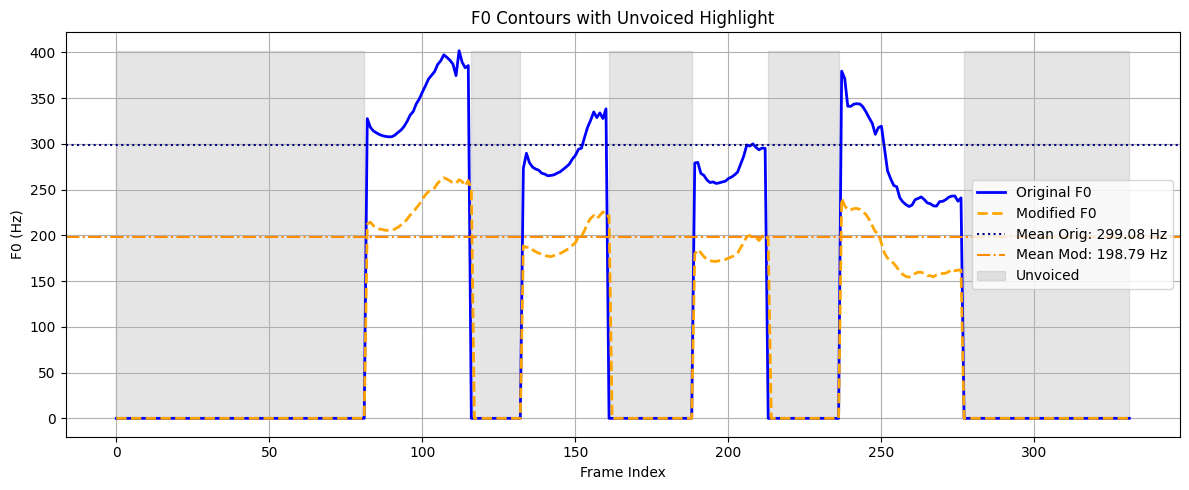

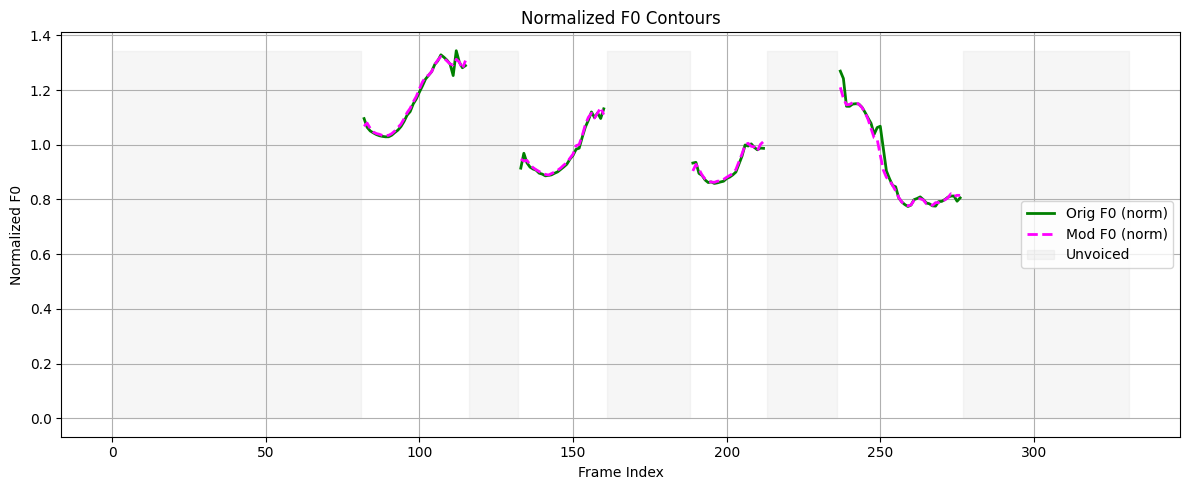

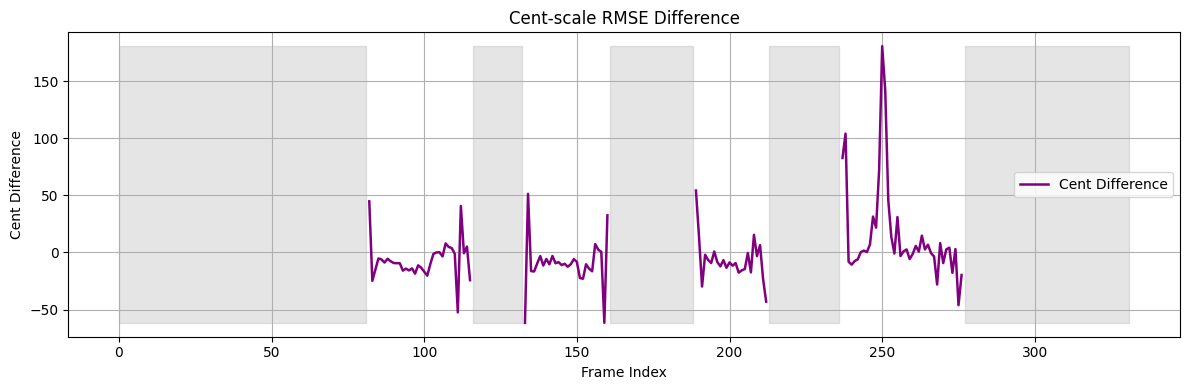

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import parselmouth

# === Extract F0 using Parselmouth ===
def extract_f0_parselmouth(wav_path,
                           time_step=0.01,
                           f0_min=150,
                           f0_max=500,
                           silence_threshold=0.03,
                           voicing_threshold=0.5,
                           octave_cost=0.01,
                           octave_jump_cost=0.35,
                           voiced_unvoiced_cost=0.14,
                           max_candidates=15):
    snd = parselmouth.Sound(wav_path)
    pitch = parselmouth.praat.call(
        snd, "To Pitch (ac)...",
        time_step, f0_min, max_candidates, f0_max,
        silence_threshold, voicing_threshold,
        octave_cost, octave_jump_cost, voiced_unvoiced_cost, f0_max
    )
    f0_values = pitch.selected_array['frequency']
    times = pitch.xs()
    voiced_mask = f0_values > 0
    return f0_values, voiced_mask, times

# === File paths ===
original_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053.WAV"
modified_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053_-7_0.85.wav"

# === Output directory to save F0 files ===
save_dir = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0_outputs/"
os.makedirs(save_dir, exist_ok=True)

# === Extract F0 ===
f0_orig, mask_orig, times_orig = extract_f0_parselmouth(original_path)
f0_mod,  mask_mod,  times_mod  = extract_f0_parselmouth(modified_path)

# === Save F0 values to text files ===
np.savetxt(os.path.join(save_dir, "000010053_F0_Original.txt"), f0_orig, fmt="%.6f")
np.savetxt(os.path.join(save_dir, "000010053_F0_Modified.txt"), f0_mod, fmt="%.6f")
print(f"✅ Saved F0 values to: {save_dir}")

# === Voiced/unvoiced mask ===
assert len(f0_orig) == len(f0_mod), "Mismatched F0 lengths"
voiced_mask = mask_orig & mask_mod
unvoiced_mask = ~voiced_mask
frame_indices = np.arange(len(f0_orig))

# === F0 values for voiced frames ===
f0_voiced_orig = f0_orig[voiced_mask]
f0_voiced_mod  = f0_mod[voiced_mask]

# === Mean F0s ===
f0_mean_orig = np.mean(f0_voiced_orig)
f0_mean_mod  = np.mean(f0_voiced_mod)
print(f"✅ Mean F0 of original (voiced): {f0_mean_orig:.4f} Hz")
print(f"✅ Mean F0 of modified (voiced): {f0_mean_mod:.4f} Hz")

# === Raw RMSE ===
f0_diff = f0_voiced_orig - f0_voiced_mod
rmse_f0 = np.sqrt(np.mean(f0_diff ** 2))
#print(f"✅ F0 RMSE (Hz): {rmse_f0:.4f}")

# === Normalization ===
f0_voiced_norm_orig = f0_voiced_orig / f0_mean_orig
f0_voiced_norm_mod  = f0_voiced_mod  / f0_mean_mod
norm_diff = f0_voiced_norm_orig - f0_voiced_norm_mod
rmse_norm = np.sqrt(np.mean(norm_diff ** 2))
#print(f"✅ Normalized F0 RMSE: {rmse_norm:.4f}")

# === Cents RMSE ===
cent_voiced_orig = 1200 * np.log2(f0_voiced_norm_orig)
cent_voiced_mod  = 1200 * np.log2(f0_voiced_norm_mod)
cent_diff = cent_voiced_orig - cent_voiced_mod
rmse_cent = np.sqrt(np.mean(cent_diff ** 2))
print(f"✅ RMSE after cent conversion: {rmse_cent:.4f}")

# === Prepare full arrays for plotting ===
f0_diff_full      = np.full_like(f0_orig, np.nan)
norm_diff_full    = np.full_like(f0_orig, np.nan)
cent_diff_full    = np.full_like(f0_orig, np.nan)
f0_norm_full_orig = np.full_like(f0_orig, np.nan)
f0_norm_full_mod  = np.full_like(f0_orig, np.nan)

f0_diff_full[voiced_mask]      = f0_diff
norm_diff_full[voiced_mask]    = norm_diff
cent_diff_full[voiced_mask]    = cent_diff
f0_norm_full_orig[voiced_mask] = f0_voiced_norm_orig
f0_norm_full_mod[voiced_mask]  = f0_voiced_norm_mod

# === Plot 1: Raw F0 contours ===
plt.figure(figsize=(12, 5))
plt.plot(f0_orig,
         label="Original F0",
         color="blue",
         linewidth=2)
plt.plot(f0_mod,
         label="Modified F0",
         color="orange",
         linestyle="--",
         linewidth=2)
plt.axhline(f0_mean_orig,
            color="navy",
            linestyle=":",
            label=f"Mean Orig: {f0_mean_orig:.2f} Hz")
plt.axhline(f0_mean_mod,
            color="darkorange",
            linestyle="-.",
            label=f"Mean Mod: {f0_mean_mod:.2f} Hz")
plt.fill_between(frame_indices, 0,
                 np.nanmax([np.nanmax(f0_orig), np.nanmax(f0_mod)]),
                 where=unvoiced_mask,
                 color="gray", alpha=0.2, label="Unvoiced")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.title("F0 Contours with Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Normalized F0 contours ===
plt.figure(figsize=(12, 5))
plt.plot(f0_norm_full_orig,
         label="Orig F0 (norm)",
         color="green",
         linewidth=2)
plt.plot(f0_norm_full_mod,
         label="Mod F0 (norm)",
         color="magenta",
         linestyle="--",
         linewidth=2)
#plt.axhline(1.0,
           # color="gray",
            #linestyle=":",
           # label="Mean (norm = 1.0)")
plt.fill_between(frame_indices, 0,
                 np.nanmax([np.nanmax(f0_norm_full_orig),
                            np.nanmax(f0_norm_full_mod)]),
                 where=unvoiced_mask,
                 color="lightgray", alpha=0.2, label="Unvoiced")
plt.xlabel("Frame Index")
plt.ylabel("Normalized F0")
plt.title("Normalized F0 Contours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: Cent-scale Difference ===
plt.figure(figsize=(12, 4))
plt.plot(cent_diff_full,
         label="Cent Difference",
         color="purple",
         linewidth=1.8)
plt.fill_between(frame_indices,
                 np.nanmin(cent_diff), np.nanmax(cent_diff),
                 where=unvoiced_mask,
                 color="gray", alpha=0.2)
#plt.axhline(0,
            #color="black",
           # linestyle="--")
plt.xlabel("Frame Index")
plt.ylabel("Cent Difference")
plt.title("Cent-scale RMSE Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Mean F0 of original (voiced): 298.1518 Hz
✅ Mean F0 of modified (voiced): 198.7447 Hz
✅ F0 RMSE (before normalization, voiced): 101.0578 Hz
✅ F0 RMSE (after normalization, voiced): 0.0325 (normalized scale)
✅ F0 RMSE (after log conversion, voiced): 0.0500 


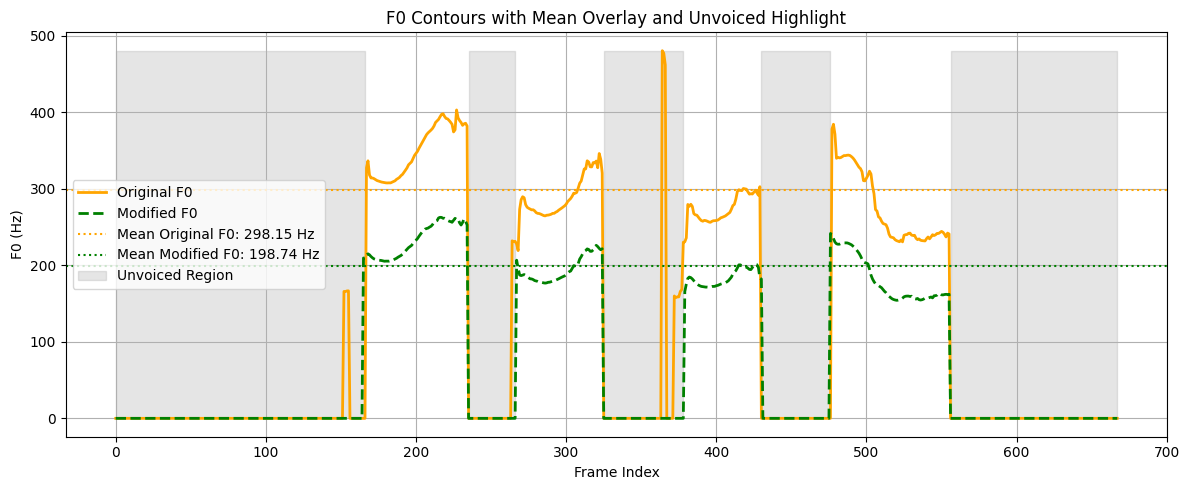

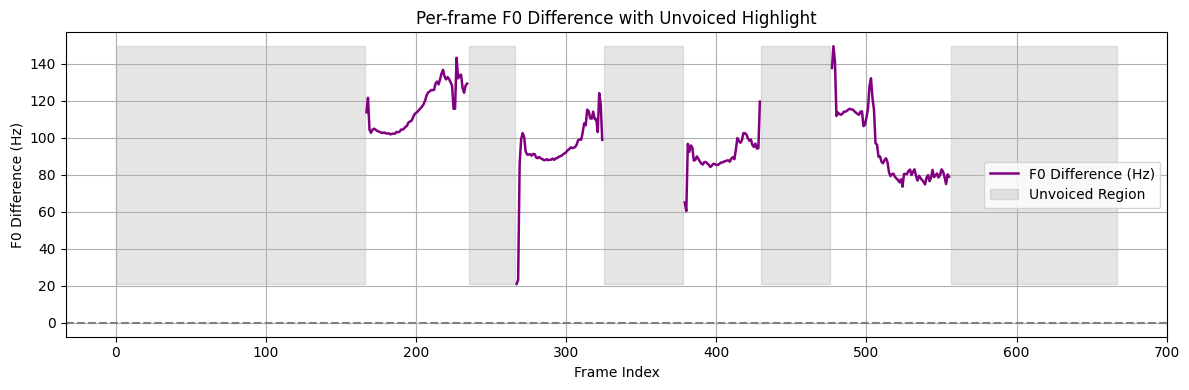

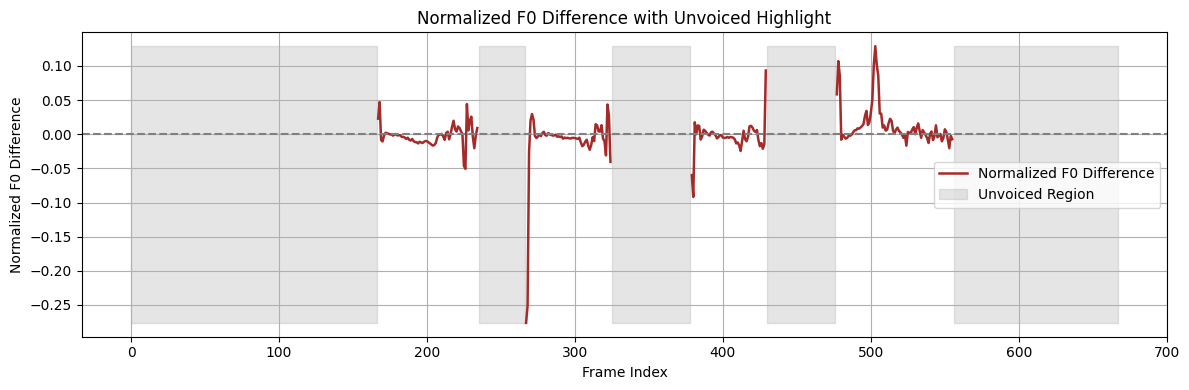

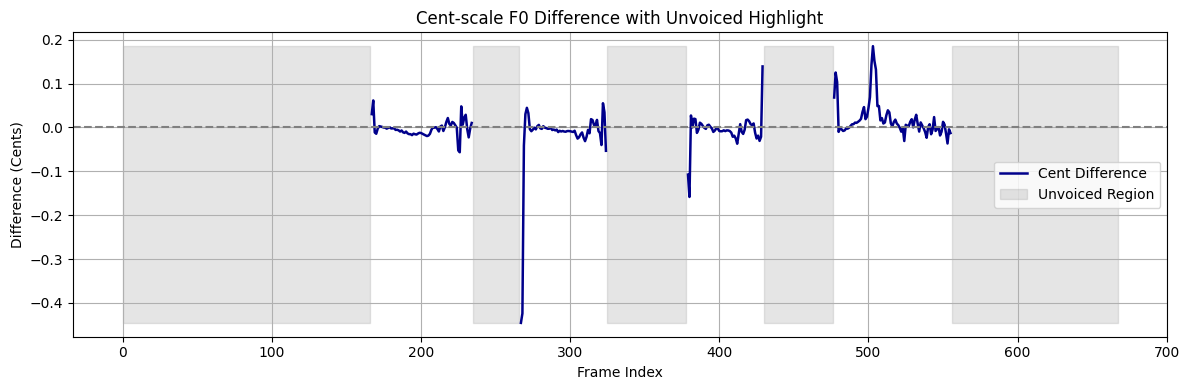

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === Load pitch data from two files ===
def load_pitch_file(filepath):
    with open(filepath, 'r') as f:
        return np.array([float(line.strip()) for line in f.readlines()])

# === Load F0 data ===
f0_orig = load_pitch_file("/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/Original_Audio_Praat.txt")
f0_mod  = load_pitch_file("/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/Modified_Audio_Praat.txt")

# === Voiced/unvoiced detection ===
voiced_mask = (f0_orig > 0) & (f0_mod > 0)
unvoiced_mask = ~voiced_mask
frame_indices = np.arange(len(f0_orig))

# === Mean F0s from voiced regions ===
f0_voiced_orig = f0_orig[voiced_mask]
f0_voiced_mod  = f0_mod[voiced_mask]

f0_mean_orig = np.mean(f0_voiced_orig)
f0_mean_mod  = np.mean(f0_voiced_mod)

print(f"✅ Mean F0 of original (voiced): {f0_mean_orig:.4f} Hz")
print(f"✅ Mean F0 of modified (voiced): {f0_mean_mod:.4f} Hz")

# === RMSE before normalization ===
f0_diff = f0_voiced_orig - f0_voiced_mod
rmse_f0 = np.sqrt(np.mean(f0_diff ** 2))
print(f"✅ F0 RMSE (before normalization, voiced): {rmse_f0:.4f} Hz")

# === Normalize voiced F0 contours ===
f0_voiced_norm_orig = f0_voiced_orig / f0_mean_orig
f0_voiced_norm_mod  = f0_voiced_mod  / f0_mean_mod

# === RMSE after normalization ===
norm_diff = f0_voiced_norm_orig - f0_voiced_norm_mod
rmse_norm = np.sqrt(np.mean(norm_diff ** 2))
print(f"✅ F0 RMSE (after normalization, voiced): {rmse_norm:.4f} (normalized scale)")

# === Convert to cents (only for voiced frames) ===
cent_voiced_orig =  np.log2(f0_voiced_norm_orig)
cent_voiced_mod  =  np.log2(f0_voiced_norm_mod)
cent_diff = cent_voiced_orig - cent_voiced_mod
rmse_cent = np.sqrt(np.mean(cent_diff ** 2))
print(f"✅ F0 RMSE (after log conversion, voiced): {rmse_cent:.4f} ")

# === Prepare full-length vectors for plotting with NaNs in unvoiced ===
f0_diff_full = np.full_like(f0_orig, np.nan)
f0_diff_full[voiced_mask] = f0_diff

norm_diff_full = np.full_like(f0_orig, np.nan)
norm_diff_full[voiced_mask] = norm_diff

cent_diff_full = np.full_like(f0_orig, np.nan)
cent_diff_full[voiced_mask] = cent_diff

# === Plot 1: Raw F0 contours with means ===
plt.figure(figsize=(12, 5))
plt.plot(f0_orig, color='orange', label="Original F0", linewidth=2)
plt.plot(f0_mod,  color='green', label="Modified F0", linewidth=2, linestyle='--')
plt.axhline(f0_mean_orig, color='orange', linestyle=':', label=f"Mean Original F0: {f0_mean_orig:.2f} Hz")
plt.axhline(f0_mean_mod,  color='green', linestyle=':',  label=f"Mean Modified F0: {f0_mean_mod:.2f} Hz")
plt.fill_between(frame_indices, 0, max(np.max(f0_orig), np.max(f0_mod)), where=unvoiced_mask,
                 color='gray', alpha=0.2, label="Unvoiced Region")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.title("F0 Contours with Mean Overlay and Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: F0 Difference (Hz) ===
plt.figure(figsize=(12, 4))
plt.plot(f0_diff_full, label="F0 Difference (Hz)", color='purple', linewidth=1.8)
plt.fill_between(frame_indices, np.nanmin(f0_diff), np.nanmax(f0_diff),
                 where=unvoiced_mask, color='gray', alpha=0.2, label='Unvoiced Region')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Frame Index")
plt.ylabel("F0 Difference (Hz)")
plt.title("Per-frame F0 Difference with Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: Normalized F0 Difference ===
plt.figure(figsize=(12, 4))
plt.plot(norm_diff_full, label="Normalized F0 Difference", color='brown', linewidth=1.8)
plt.fill_between(frame_indices, np.nanmin(norm_diff), np.nanmax(norm_diff),
                 where=unvoiced_mask, color='gray', alpha=0.2, label='Unvoiced Region')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Frame Index")
plt.ylabel("Normalized F0 Difference")
plt.title("Normalized F0 Difference with Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 4: Cent-scale F0 Difference ===
plt.figure(figsize=(12, 4))
plt.plot(cent_diff_full, label="Cent Difference", color='darkblue', linewidth=1.8)
plt.fill_between(frame_indices, np.nanmin(cent_diff), np.nanmax(cent_diff),
                 where=unvoiced_mask, color='gray', alpha=0.2, label='Unvoiced Region')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Frame Index")
plt.ylabel("Difference (Cents)")
plt.title("Cent-scale F0 Difference with Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Saved F0 values to: /home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0_outputs/
✅ Mean F0 of original (voiced): 274.7734 Hz
✅ Mean F0 of modified (voiced): 276.9194 Hz
✅ RMSE after cent conversion: 59.8724


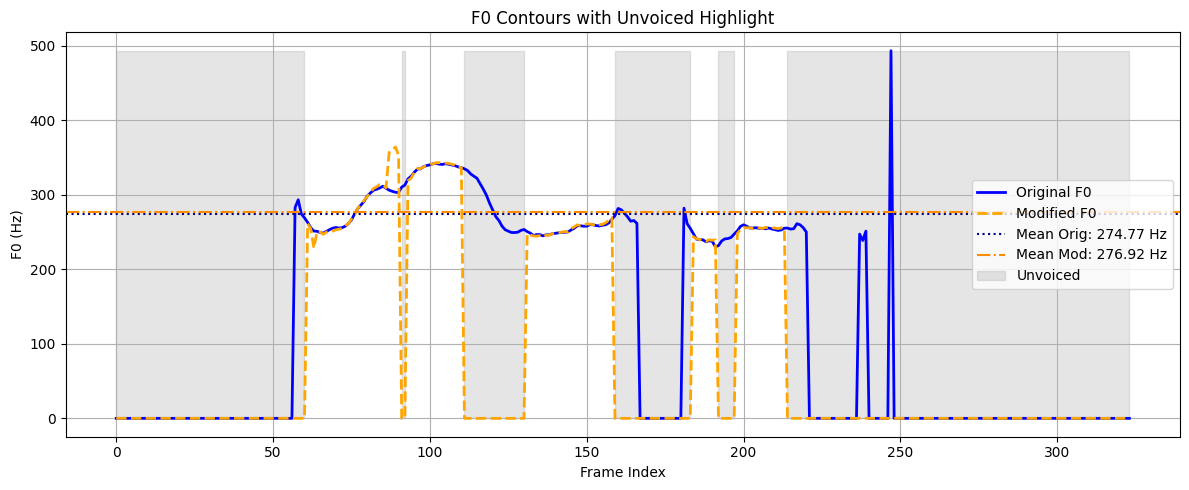

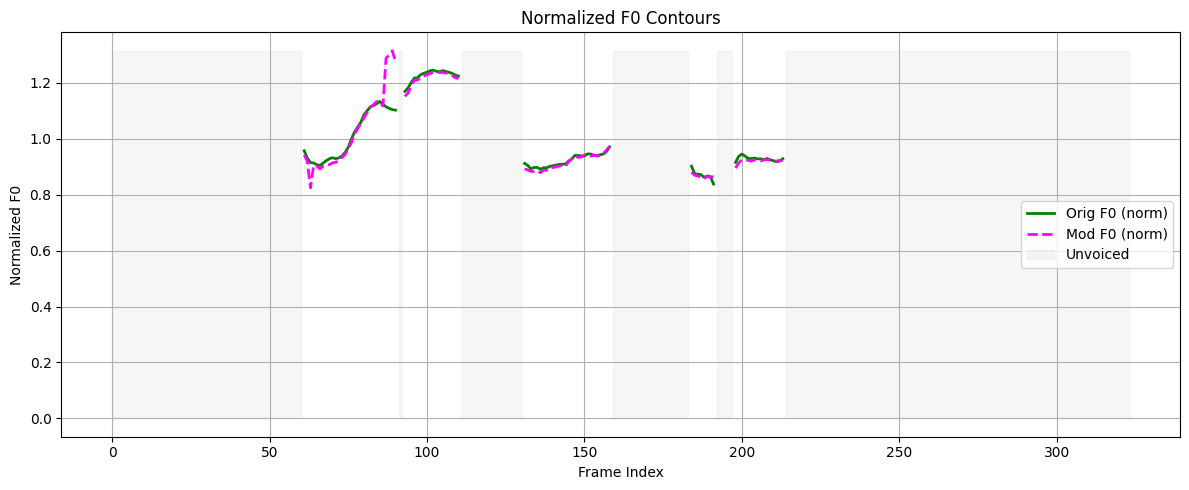

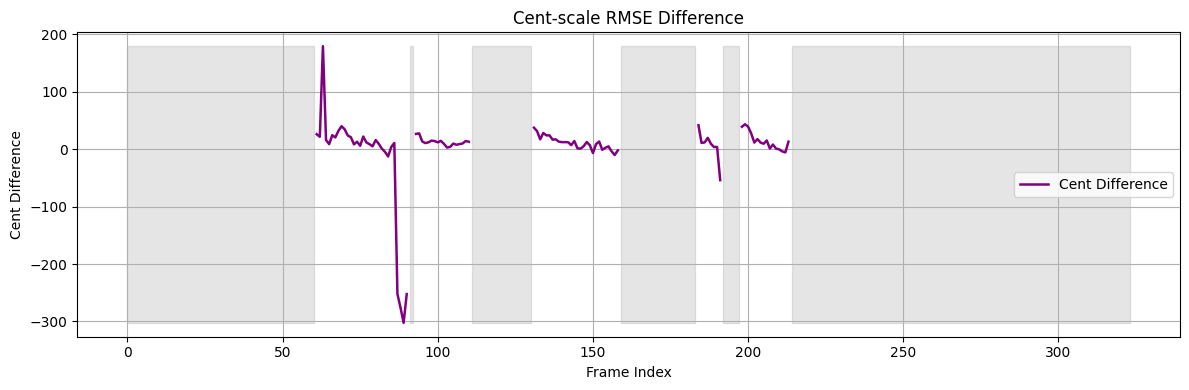

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import parselmouth

# === Extract F0 using Parselmouth ===
def extract_f0_parselmouth(wav_path,
                           time_step=0.01,
                           f0_min=150,
                           f0_max=500,
                           silence_threshold=0.03,
                           voicing_threshold=0.5,
                           octave_cost=0.01,
                           octave_jump_cost=0.35,
                           voiced_unvoiced_cost=0.14,
                           max_candidates=15):
    snd = parselmouth.Sound(wav_path)
    pitch = parselmouth.praat.call(
        snd, "To Pitch (ac)...",
        time_step, f0_min, max_candidates, f0_max,
        silence_threshold, voicing_threshold,
        octave_cost, octave_jump_cost, voiced_unvoiced_cost, f0_max
    )
    f0_values = pitch.selected_array['frequency']
    times = pitch.xs()
    voiced_mask = f0_values > 0
    return f0_values, voiced_mask, times

# === File paths ===
original_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/O_000940042.wav"
modified_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/MA_94-940042.wav"

# === Output directory to save F0 files ===
save_dir = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0_outputs/"
os.makedirs(save_dir, exist_ok=True)

# === Extract F0 ===
f0_orig, mask_orig, times_orig = extract_f0_parselmouth(original_path)
f0_mod,  mask_mod,  times_mod  = extract_f0_parselmouth(modified_path)

# === Save F0 values to text files ===
np.savetxt(os.path.join(save_dir, "000010053_F0_Original.txt"), f0_orig, fmt="%.6f")
np.savetxt(os.path.join(save_dir, "000010053_F0_Modified.txt"), f0_mod, fmt="%.6f")
print(f"✅ Saved F0 values to: {save_dir}")

# === Voiced/unvoiced mask ===
assert len(f0_orig) == len(f0_mod), "Mismatched F0 lengths"
voiced_mask = mask_orig & mask_mod
unvoiced_mask = ~voiced_mask
frame_indices = np.arange(len(f0_orig))

# === F0 values for voiced frames ===
f0_voiced_orig = f0_orig[voiced_mask]
f0_voiced_mod  = f0_mod[voiced_mask]

# === Mean F0s ===
f0_mean_orig = np.mean(f0_voiced_orig)
f0_mean_mod  = np.mean(f0_voiced_mod)
print(f"✅ Mean F0 of original (voiced): {f0_mean_orig:.4f} Hz")
print(f"✅ Mean F0 of modified (voiced): {f0_mean_mod:.4f} Hz")

# === Raw RMSE ===
f0_diff = f0_voiced_orig - f0_voiced_mod
rmse_f0 = np.sqrt(np.mean(f0_diff ** 2))
#print(f"✅ F0 RMSE (Hz): {rmse_f0:.4f}")

# === Normalization ===
f0_voiced_norm_orig = f0_voiced_orig / f0_mean_orig
f0_voiced_norm_mod  = f0_voiced_mod  / f0_mean_mod
norm_diff = f0_voiced_norm_orig - f0_voiced_norm_mod
rmse_norm = np.sqrt(np.mean(norm_diff ** 2))
#print(f"✅ Normalized F0 RMSE: {rmse_norm:.4f}")

# === Cents RMSE ===
cent_voiced_orig = 1200 * np.log2(f0_voiced_norm_orig)
cent_voiced_mod  = 1200 * np.log2(f0_voiced_norm_mod)
cent_diff = cent_voiced_orig - cent_voiced_mod
rmse_cent = np.sqrt(np.mean(cent_diff ** 2))
print(f"✅ RMSE after cent conversion: {rmse_cent:.4f}")

# === Prepare full arrays for plotting ===
f0_diff_full      = np.full_like(f0_orig, np.nan)
norm_diff_full    = np.full_like(f0_orig, np.nan)
cent_diff_full    = np.full_like(f0_orig, np.nan)
f0_norm_full_orig = np.full_like(f0_orig, np.nan)
f0_norm_full_mod  = np.full_like(f0_orig, np.nan)

f0_diff_full[voiced_mask]      = f0_diff
norm_diff_full[voiced_mask]    = norm_diff
cent_diff_full[voiced_mask]    = cent_diff
f0_norm_full_orig[voiced_mask] = f0_voiced_norm_orig
f0_norm_full_mod[voiced_mask]  = f0_voiced_norm_mod

# === Plot 1: Raw F0 contours ===
plt.figure(figsize=(12, 5))
plt.plot(f0_orig,
         label="Original F0",
         color="blue",
         linewidth=2)
plt.plot(f0_mod,
         label="Modified F0",
         color="orange",
         linestyle="--",
         linewidth=2)
plt.axhline(f0_mean_orig,
            color="navy",
            linestyle=":",
            label=f"Mean Orig: {f0_mean_orig:.2f} Hz")
plt.axhline(f0_mean_mod,
            color="darkorange",
            linestyle="-.",
            label=f"Mean Mod: {f0_mean_mod:.2f} Hz")
plt.fill_between(frame_indices, 0,
                 np.nanmax([np.nanmax(f0_orig), np.nanmax(f0_mod)]),
                 where=unvoiced_mask,
                 color="gray", alpha=0.2, label="Unvoiced")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.title("F0 Contours with Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Normalized F0 contours ===
plt.figure(figsize=(12, 5))
plt.plot(f0_norm_full_orig,
         label="Orig F0 (norm)",
         color="green",
         linewidth=2)
plt.plot(f0_norm_full_mod,
         label="Mod F0 (norm)",
         color="magenta",
         linestyle="--",
         linewidth=2)
#plt.axhline(1.0,
           # color="gray",
            #linestyle=":",
           # label="Mean (norm = 1.0)")
plt.fill_between(frame_indices, 0,
                 np.nanmax([np.nanmax(f0_norm_full_orig),
                            np.nanmax(f0_norm_full_mod)]),
                 where=unvoiced_mask,
                 color="lightgray", alpha=0.2, label="Unvoiced")
plt.xlabel("Frame Index")
plt.ylabel("Normalized F0")
plt.title("Normalized F0 Contours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: Cent-scale Difference ===
plt.figure(figsize=(12, 4))
plt.plot(cent_diff_full,
         label="Cent Difference",
         color="purple",
         linewidth=1.8)
plt.fill_between(frame_indices,
                 np.nanmin(cent_diff), np.nanmax(cent_diff),
                 where=unvoiced_mask,
                 color="gray", alpha=0.2)
#plt.axhline(0,
            #color="black",
           # linestyle="--")
plt.xlabel("Frame Index")
plt.ylabel("Cent Difference")
plt.title("Cent-scale RMSE Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Saved F0 values to: /home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0_outputs/
✅ Mean F0 of original (voiced): 273.5778 Hz
✅ Mean F0 of modified (voiced): 182.5123 Hz
✅ RMSE after cent conversion: 12.3669


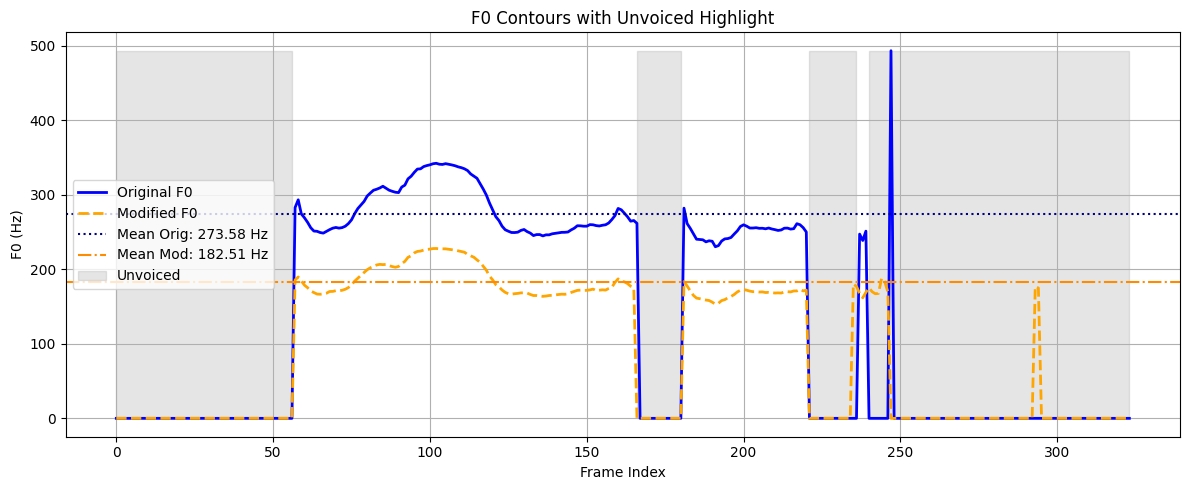

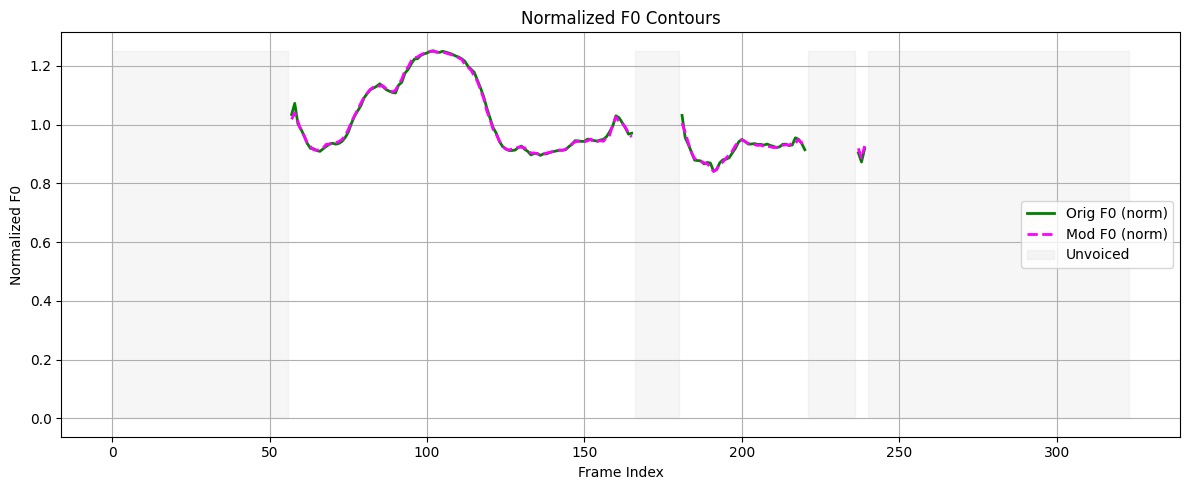

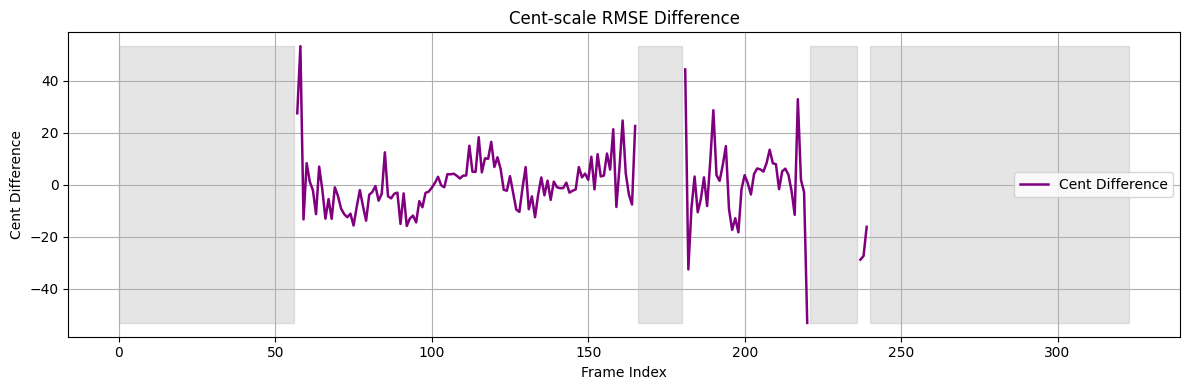

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import parselmouth

# === Extract F0 using Parselmouth ===
def extract_f0_parselmouth(wav_path,
                           time_step=0.01,
                           f0_min=150,
                           f0_max=500,
                           silence_threshold=0.03,
                           voicing_threshold=0.5,
                           octave_cost=0.01,
                           octave_jump_cost=0.35,
                           voiced_unvoiced_cost=0.14,
                           max_candidates=15):
    snd = parselmouth.Sound(wav_path)
    pitch = parselmouth.praat.call(
        snd, "To Pitch (ac)...",
        time_step, f0_min, max_candidates, f0_max,
        silence_threshold, voicing_threshold,
        octave_cost, octave_jump_cost, voiced_unvoiced_cost, f0_max
    )
    f0_values = pitch.selected_array['frequency']
    times = pitch.xs()
    voiced_mask = f0_values > 0
    return f0_values, voiced_mask, times

# === File paths ===
original_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/O_000940042.wav"
modified_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/O_000940042_warp0.85_ps-7.0.wav"

# === Output directory to save F0 files ===
save_dir = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0_outputs/"
os.makedirs(save_dir, exist_ok=True)

# === Extract F0 ===
f0_orig, mask_orig, times_orig = extract_f0_parselmouth(original_path)
f0_mod,  mask_mod,  times_mod  = extract_f0_parselmouth(modified_path)

# === Save F0 values to text files ===
np.savetxt(os.path.join(save_dir, "000010053_F0_Original.txt"), f0_orig, fmt="%.6f")
np.savetxt(os.path.join(save_dir, "000010053_F0_Modified.txt"), f0_mod, fmt="%.6f")
print(f"✅ Saved F0 values to: {save_dir}")

# === Voiced/unvoiced mask ===
assert len(f0_orig) == len(f0_mod), "Mismatched F0 lengths"
voiced_mask = mask_orig & mask_mod
unvoiced_mask = ~voiced_mask
frame_indices = np.arange(len(f0_orig))

# === F0 values for voiced frames ===
f0_voiced_orig = f0_orig[voiced_mask]
f0_voiced_mod  = f0_mod[voiced_mask]

# === Mean F0s ===
f0_mean_orig = np.mean(f0_voiced_orig)
f0_mean_mod  = np.mean(f0_voiced_mod)
print(f"✅ Mean F0 of original (voiced): {f0_mean_orig:.4f} Hz")
print(f"✅ Mean F0 of modified (voiced): {f0_mean_mod:.4f} Hz")

# === Raw RMSE ===
f0_diff = f0_voiced_orig - f0_voiced_mod
rmse_f0 = np.sqrt(np.mean(f0_diff ** 2))
#print(f"✅ F0 RMSE (Hz): {rmse_f0:.4f}")

# === Normalization ===
f0_voiced_norm_orig = f0_voiced_orig / f0_mean_orig
f0_voiced_norm_mod  = f0_voiced_mod  / f0_mean_mod
norm_diff = f0_voiced_norm_orig - f0_voiced_norm_mod
rmse_norm = np.sqrt(np.mean(norm_diff ** 2))
#print(f"✅ Normalized F0 RMSE: {rmse_norm:.4f}")

# === Cents RMSE ===
cent_voiced_orig = 1200 * np.log2(f0_voiced_norm_orig)
cent_voiced_mod  = 1200 * np.log2(f0_voiced_norm_mod)
cent_diff = cent_voiced_orig - cent_voiced_mod
rmse_cent = np.sqrt(np.mean(cent_diff ** 2))
print(f"✅ RMSE after cent conversion: {rmse_cent:.4f}")

# === Prepare full arrays for plotting ===
f0_diff_full      = np.full_like(f0_orig, np.nan)
norm_diff_full    = np.full_like(f0_orig, np.nan)
cent_diff_full    = np.full_like(f0_orig, np.nan)
f0_norm_full_orig = np.full_like(f0_orig, np.nan)
f0_norm_full_mod  = np.full_like(f0_orig, np.nan)

f0_diff_full[voiced_mask]      = f0_diff
norm_diff_full[voiced_mask]    = norm_diff
cent_diff_full[voiced_mask]    = cent_diff
f0_norm_full_orig[voiced_mask] = f0_voiced_norm_orig
f0_norm_full_mod[voiced_mask]  = f0_voiced_norm_mod

# === Plot 1: Raw F0 contours ===
plt.figure(figsize=(12, 5))
plt.plot(f0_orig,
         label="Original F0",
         color="blue",
         linewidth=2)
plt.plot(f0_mod,
         label="Modified F0",
         color="orange",
         linestyle="--",
         linewidth=2)
plt.axhline(f0_mean_orig,
            color="navy",
            linestyle=":",
            label=f"Mean Orig: {f0_mean_orig:.2f} Hz")
plt.axhline(f0_mean_mod,
            color="darkorange",
            linestyle="-.",
            label=f"Mean Mod: {f0_mean_mod:.2f} Hz")
plt.fill_between(frame_indices, 0,
                 np.nanmax([np.nanmax(f0_orig), np.nanmax(f0_mod)]),
                 where=unvoiced_mask,
                 color="gray", alpha=0.2, label="Unvoiced")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.title("F0 Contours with Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Normalized F0 contours ===
plt.figure(figsize=(12, 5))
plt.plot(f0_norm_full_orig,
         label="Orig F0 (norm)",
         color="green",
         linewidth=2)
plt.plot(f0_norm_full_mod,
         label="Mod F0 (norm)",
         color="magenta",
         linestyle="--",
         linewidth=2)
#plt.axhline(1.0,
           # color="gray",
            #linestyle=":",
           # label="Mean (norm = 1.0)")
plt.fill_between(frame_indices, 0,
                 np.nanmax([np.nanmax(f0_norm_full_orig),
                            np.nanmax(f0_norm_full_mod)]),
                 where=unvoiced_mask,
                 color="lightgray", alpha=0.2, label="Unvoiced")
plt.xlabel("Frame Index")
plt.ylabel("Normalized F0")
plt.title("Normalized F0 Contours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: Cent-scale Difference ===
plt.figure(figsize=(12, 4))
plt.plot(cent_diff_full,
         label="Cent Difference",
         color="purple",
         linewidth=1.8)
plt.fill_between(frame_indices,
                 np.nanmin(cent_diff), np.nanmax(cent_diff),
                 where=unvoiced_mask,
                 color="gray", alpha=0.2)
#plt.axhline(0,
            #color="black",
           # linestyle="--")
plt.xlabel("Frame Index")
plt.ylabel("Cent Difference")
plt.title("Cent-scale RMSE Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Saved F0 values to: /home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0_outputs/
✅ Mean F0 of original (voiced): 299.0755 Hz
✅ Mean F0 of modified (voiced): 198.7917 Hz
len of f0_voiced_norm_orig 126
✅ RMSE after cent conversion: 30.7580


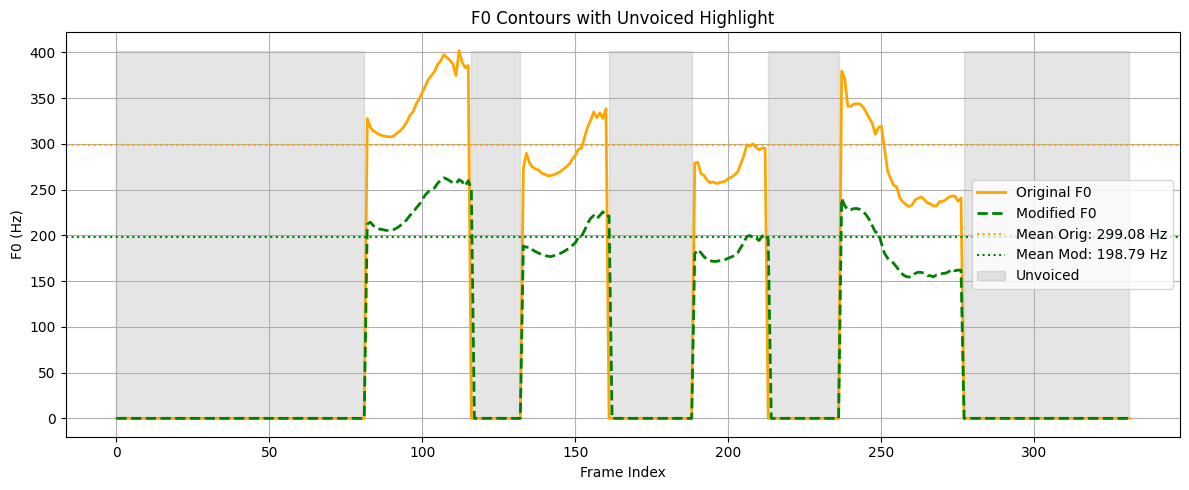

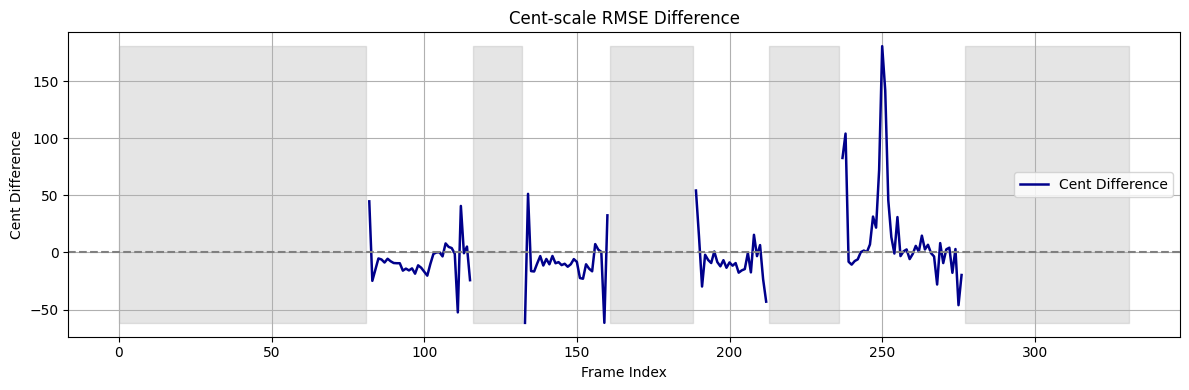

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import parselmouth

# === Extract F0 using Parselmouth ===
def extract_f0_parselmouth(wav_path,
                           time_step=0.01,
                           f0_min=150,
                           f0_max=500,
                           silence_threshold=0.03,
                           voicing_threshold=0.5,
                           octave_cost=0.01,
                           octave_jump_cost=0.35,
                           voiced_unvoiced_cost=0.14,
                           max_candidates=15):
    snd = parselmouth.Sound(wav_path)
    pitch = parselmouth.praat.call(
        snd, "To Pitch (ac)...",
        time_step, f0_min, max_candidates, f0_max,
        silence_threshold, voicing_threshold,
        octave_cost, octave_jump_cost, voiced_unvoiced_cost, f0_max
    )
    f0_values = pitch.selected_array['frequency']
    times = pitch.xs()
    voiced_mask = f0_values > 0
    return f0_values, voiced_mask, times, snd


# === File paths ===
original_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053.WAV"
modified_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053_-7_0.85.wav"

# === Output directory to save F0 files ===
save_dir = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0_outputs/"
os.makedirs(save_dir, exist_ok=True)

# === Extract F0 ===
f0_orig, mask_orig, times_orig, _ = extract_f0_parselmouth(original_path)
f0_mod,  mask_mod,  times_mod,  _ = extract_f0_parselmouth(modified_path)

# === Save F0 values to text files ===
np.savetxt(os.path.join(save_dir, "000010053_F0_Original.txt"), f0_orig, fmt="%.6f")
np.savetxt(os.path.join(save_dir, "000010053_F0_Modified.txt"), f0_mod, fmt="%.6f")
print(f"✅ Saved F0 values to: {save_dir}")

# === Voiced/unvoiced mask ===
assert len(f0_orig) == len(f0_mod), "Mismatched F0 lengths"
voiced_mask = mask_orig & mask_mod
unvoiced_mask = ~voiced_mask
frame_indices = np.arange(len(f0_orig))

# === F0 values for voiced frames ===
f0_voiced_orig = f0_orig[voiced_mask]
f0_voiced_mod  = f0_mod[voiced_mask]

# === Mean F0s ===
f0_mean_orig = np.mean(f0_voiced_orig)
f0_mean_mod  = np.mean(f0_voiced_mod)

print(f"✅ Mean F0 of original (voiced): {f0_mean_orig:.4f} Hz")
print(f"✅ Mean F0 of modified (voiced): {f0_mean_mod:.4f} Hz")

# === Raw RMSE ===
f0_diff = f0_voiced_orig - f0_voiced_mod
rmse_f0 = np.sqrt(np.mean(f0_diff ** 2))
#print(f"✅ F0 RMSE (Hz): {rmse_f0:.4f}")

# === Normalized RMSE ===
f0_voiced_norm_orig = f0_voiced_orig / f0_mean_orig
f0_voiced_norm_mod  = f0_voiced_mod  / f0_mean_mod
norm_diff = f0_voiced_norm_orig - f0_voiced_norm_mod
rmse_norm = np.sqrt(np.mean(norm_diff ** 2))
#print(f"✅ F0 RMSE (Normalized): {rmse_norm:.4f}")

# === Cents RMSE ===
print(f"len of f0_voiced_norm_orig {len(f0_voiced_norm_orig)}")
cent_voiced_orig = 1200 * np.log2(f0_voiced_norm_orig)
cent_voiced_mod  = 1200 * np.log2(f0_voiced_norm_mod)
cent_diff = cent_voiced_orig - cent_voiced_mod
rmse_cent = np.sqrt(np.mean(cent_diff ** 2))
print(f"✅ RMSE after cent conversion: {rmse_cent:.4f}")

# === Prepare full arrays for plotting ===
f0_diff_full = np.full_like(f0_orig, np.nan)
norm_diff_full = np.full_like(f0_orig, np.nan)
cent_diff_full = np.full_like(f0_orig, np.nan)
f0_diff_full[voiced_mask]   = f0_diff
norm_diff_full[voiced_mask] = norm_diff
cent_diff_full[voiced_mask] = cent_diff

# === Plot 1: F0 contours ===
plt.figure(figsize=(12, 5))
plt.plot(f0_orig, color='orange', label="Original F0", linewidth=2)
plt.plot(f0_mod, color='green', label="Modified F0", linestyle='--', linewidth=2)
plt.axhline(f0_mean_orig, color='orange', linestyle=':', label=f"Mean Orig: {f0_mean_orig:.2f} Hz")
plt.axhline(f0_mean_mod,  color='green', linestyle=':',  label=f"Mean Mod: {f0_mean_mod:.2f} Hz")
plt.fill_between(frame_indices, 0, max(np.max(f0_orig), np.max(f0_mod)),
                 where=unvoiced_mask, color='gray', alpha=0.2, label="Unvoiced")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.title("F0 Contours with Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# === Plot 4: Cent-scale Difference ===
plt.figure(figsize=(12, 4))
plt.plot(cent_diff_full, label="Cent Difference", color='darkblue', linewidth=1.8)
plt.fill_between(frame_indices, np.nanmin(cent_diff), np.nanmax(cent_diff),
                 where=unvoiced_mask, color='gray', alpha=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Frame Index")
plt.ylabel("Cent Difference")
plt.title("Cent-scale RMSE Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ F0 trajectories saved row-wise with filenames to: /home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0-Contour-McAdams/F0_Trajectories_RowWise_ByFilename.csv
✅ Mean F0 of original (voiced): 296.6931 Hz
✅ Mean F0 of modified (voiced): 295.0328 Hz
✅ F0 RMSE (Hz): 5.9264
✅ Normalized F0 RMSE: 0.0193
✅ RMSE in cents: 34.6480


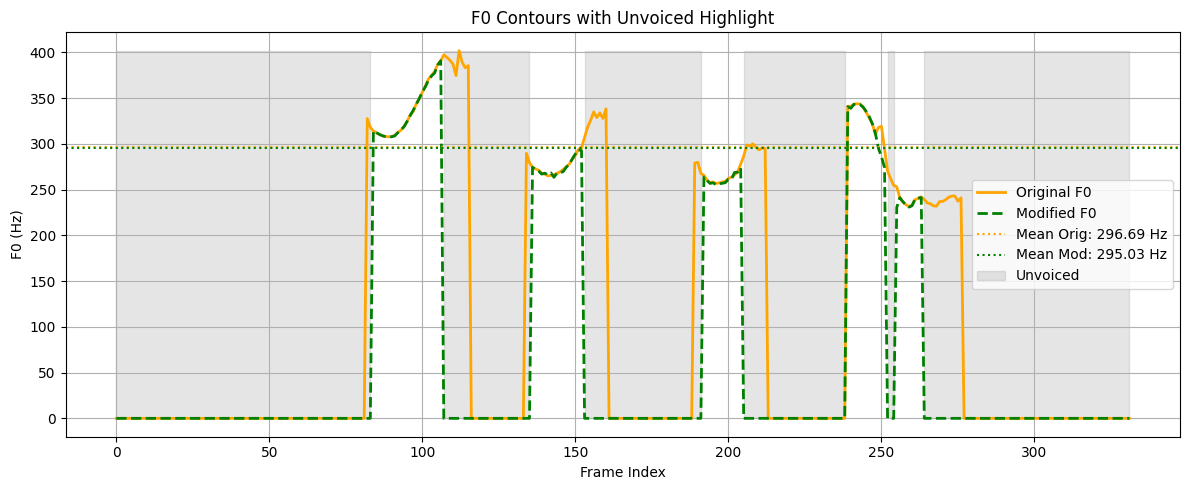

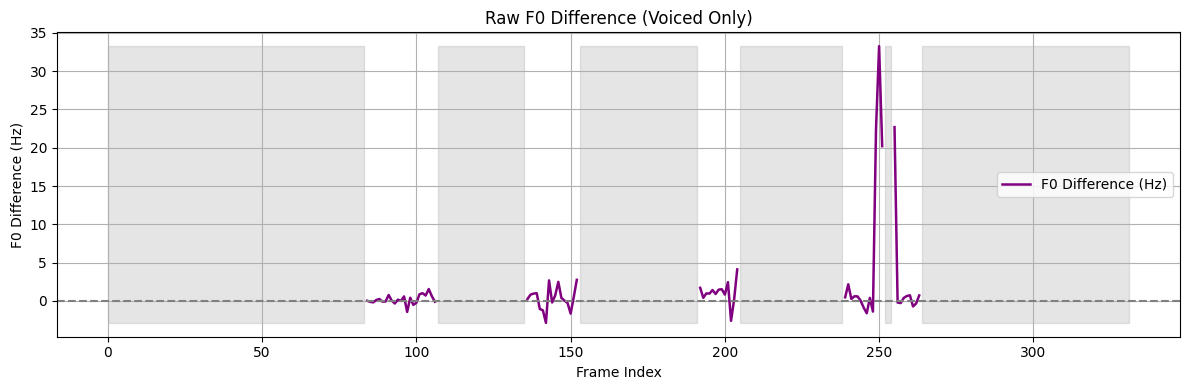

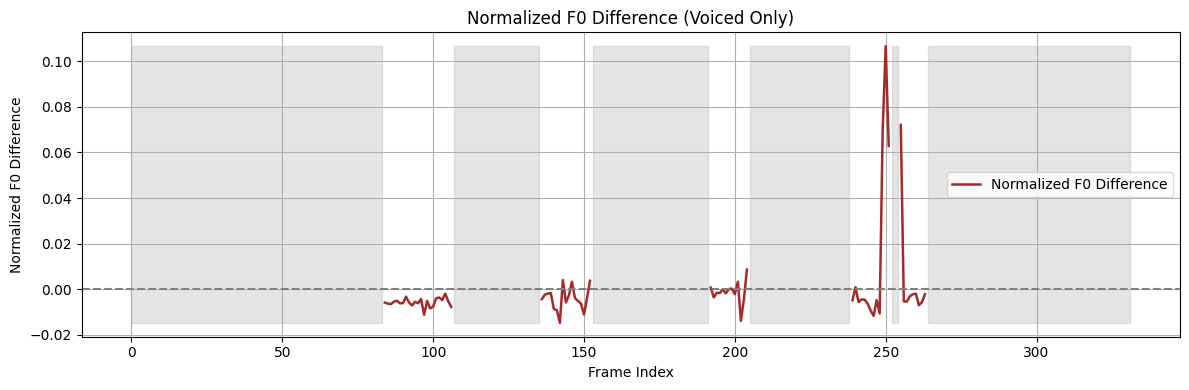

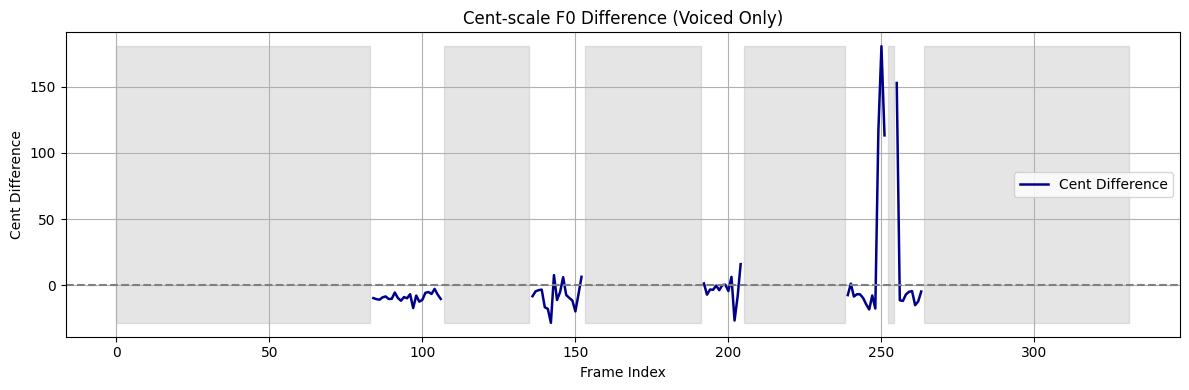

In [22]:
import os
import numpy as np
import parselmouth
import pandas as pd
import matplotlib.pyplot as plt

# === Extract F0 using Parselmouth ===
def extract_f0_parselmouth(wav_path,
                           time_step=0.01,
                           f0_min=150,
                           f0_max=500,
                           silence_threshold=0.03,
                           voicing_threshold=0.65,
                           octave_cost=0.01,
                           octave_jump_cost=0.35,
                           voiced_unvoiced_cost=0.14,
                           max_candidates=15):
    snd = parselmouth.Sound(wav_path)
    pitch = parselmouth.praat.call(
        snd, "To Pitch (ac)...",
        time_step, f0_min, max_candidates, f0_max,
        silence_threshold, voicing_threshold,
        octave_cost, octave_jump_cost, voiced_unvoiced_cost, f0_max
    )
    f0_values = pitch.selected_array['frequency']
    voiced_mask = f0_values > 0
    return f0_values, voiced_mask

# === File paths ===
original_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053.wav"
modified_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053_0.8.wav"

# === Output directory ===
save_dir = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0-Contour-McAdams/"
os.makedirs(save_dir, exist_ok=True)

# === Extract F0 and voiced mask ===
f0_orig, mask_orig = extract_f0_parselmouth(original_path)
f0_mod,  mask_mod  = extract_f0_parselmouth(modified_path)

# === Pad shorter signal with zeros
len_orig = len(f0_orig)
len_mod = len(f0_mod)

if len_orig > len_mod:
    pad_len = len_orig - len_mod
    f0_mod = np.pad(f0_mod, (0, pad_len), constant_values=0)
    mask_mod = np.pad(mask_mod, (0, pad_len), constant_values=False)
elif len_mod > len_orig:
    pad_len = len_mod - len_orig
    f0_orig = np.pad(f0_orig, (0, pad_len), constant_values=0)
    mask_orig = np.pad(mask_orig, (0, pad_len), constant_values=False)

assert len(f0_orig) == len(f0_mod), "Lengths must match after padding"
assert len(mask_orig) == len(mask_mod), "Mask lengths must also match"

# === Store F0 values (row-wise) with filename as index
orig_name = os.path.splitext(os.path.basename(original_path))[0]
mod_name = os.path.splitext(os.path.basename(modified_path))[0]

df_orig = pd.DataFrame([f0_orig], index=[orig_name])
df_mod = pd.DataFrame([f0_mod], index=[mod_name])

f0_all_df = pd.concat([df_orig, df_mod])
f0_all_df.index.name = "Filename"

csv_path = os.path.join(save_dir, "F0_Trajectories_RowWise_ByFilename.csv")
f0_all_df.to_csv(csv_path)
print(f"✅ F0 trajectories saved row-wise with filenames to: {csv_path}")

# === Frame indices
frame_indices = np.arange(len(f0_orig))

# === Combined voiced mask (logical AND)
voiced_mask = mask_orig & mask_mod
unvoiced_mask = ~voiced_mask

# === Voiced F0 values only
f0_voiced_orig = f0_orig[voiced_mask]
f0_voiced_mod  = f0_mod[voiced_mask]

# === Mean F0
f0_mean_orig = np.mean(f0_voiced_orig)
f0_mean_mod  = np.mean(f0_voiced_mod)
print(f"✅ Mean F0 of original (voiced): {f0_mean_orig:.4f} Hz")
print(f"✅ Mean F0 of modified (voiced): {f0_mean_mod:.4f} Hz")

# === RMSE (raw)
f0_diff = f0_voiced_orig - f0_voiced_mod
rmse_f0 = np.sqrt(np.mean(f0_diff ** 2))
print(f"✅ F0 RMSE (Hz): {rmse_f0:.4f}")

# === Normalized RMSE
f0_voiced_norm_orig = f0_voiced_orig / f0_mean_orig
f0_voiced_norm_mod  = f0_voiced_mod / f0_mean_mod
norm_diff = f0_voiced_norm_orig - f0_voiced_norm_mod
rmse_norm = np.sqrt(np.mean(norm_diff ** 2))
print(f"✅ Normalized F0 RMSE: {rmse_norm:.4f}")

# === RMSE in Cents
cent_voiced_orig = 1200 * np.log2(f0_voiced_norm_orig)
cent_voiced_mod  = 1200 * np.log2(f0_voiced_norm_mod)
cent_diff = cent_voiced_orig - cent_voiced_mod
rmse_cent = np.sqrt(np.mean(cent_diff ** 2))
print(f"✅ RMSE in cents: {rmse_cent:.4f}")

# === Prepare full arrays for plots
f0_diff_full = np.full_like(f0_orig, np.nan)
norm_diff_full = np.full_like(f0_orig, np.nan)
cent_diff_full = np.full_like(f0_orig, np.nan)

f0_diff_full[voiced_mask] = f0_diff
norm_diff_full[voiced_mask] = norm_diff
cent_diff_full[voiced_mask] = cent_diff

# === Plot 1: F0 contours
plt.figure(figsize=(12, 5))
plt.plot(f0_orig, color='orange', label="Original F0", linewidth=2)
plt.plot(f0_mod, color='green', label="Modified F0", linestyle='--', linewidth=2)
plt.axhline(f0_mean_orig, color='orange', linestyle=':', label=f"Mean Orig: {f0_mean_orig:.2f} Hz")
plt.axhline(f0_mean_mod,  color='green', linestyle=':', label=f"Mean Mod: {f0_mean_mod:.2f} Hz")
plt.fill_between(frame_indices, 0, np.max([f0_orig.max(), f0_mod.max()]),
                 where=unvoiced_mask, color='gray', alpha=0.2, label="Unvoiced")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.title("F0 Contours with Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Raw F0 Difference
plt.figure(figsize=(12, 4))
plt.plot(f0_diff_full, label="F0 Difference (Hz)", color='purple', linewidth=1.8)
plt.fill_between(frame_indices, np.nanmin(f0_diff), np.nanmax(f0_diff),
                 where=unvoiced_mask, color='gray', alpha=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Frame Index")
plt.ylabel("F0 Difference (Hz)")
plt.title("Raw F0 Difference (Voiced Only)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: Normalized F0 Difference
plt.figure(figsize=(12, 4))
plt.plot(norm_diff_full, label="Normalized F0 Difference", color='brown', linewidth=1.8)
plt.fill_between(frame_indices, np.nanmin(norm_diff), np.nanmax(norm_diff),
                 where=unvoiced_mask, color='gray', alpha=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Frame Index")
plt.ylabel("Normalized F0 Difference")
plt.title("Normalized F0 Difference (Voiced Only)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 4: Cent-scale Difference
plt.figure(figsize=(12, 4))
plt.plot(cent_diff_full, label="Cent Difference", color='darkblue', linewidth=1.8)
plt.fill_between(frame_indices, np.nanmin(cent_diff), np.nanmax(cent_diff),
                 where=unvoiced_mask, color='gray', alpha=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Frame Index")
plt.ylabel("Cent Difference")
plt.title("Cent-scale F0 Difference (Voiced Only)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
# Re-import necessary modules after code execution state reset
import os
import numpy as np
import parselmouth
import pandas as pd
import matplotlib.pyplot as plt

# === Extract F0 using Parselmouth ===
def extract_f0_parselmouth(wav_path,
                           time_step=0.01,
                           f0_min=150,
                           f0_max=500,
                           silence_threshold=0.03,
                           voicing_threshold=0.3,
                           octave_cost=0.01,
                           octave_jump_cost=0.35,
                           voiced_unvoiced_cost=0.14,
                           max_candidates=15):
    snd = parselmouth.Sound(wav_path)
    pitch = parselmouth.praat.call(
        snd, "To Pitch (ac)...",
        time_step, f0_min, max_candidates, f0_max,
        silence_threshold, voicing_threshold,
        octave_cost, octave_jump_cost, voiced_unvoiced_cost, f0_max
    )
    f0_values = pitch.selected_array['frequency']
    return f0_values

# === File paths ===
# original_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053.wav"
# modified_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053_-7_0.85.wav"
original_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053.wav"
modified_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053_0.8.wav"
# === Extract F0 values ===
f0_orig = extract_f0_parselmouth(original_path)
f0_mod = extract_f0_parselmouth(modified_path)

# === Pad to equal length ===
len_orig = len(f0_orig)
len_mod = len(f0_mod)
max_len = max(len_orig, len_mod)

f0_orig_padded = np.pad(f0_orig, (0, max_len - len_orig), constant_values=0.0)
f0_mod_padded = np.pad(f0_mod, (0, max_len - len_mod), constant_values=0.0)

# === Voicing masks ===
voiced_orig = f0_orig_padded > 0
voiced_mod = f0_mod_padded > 0

# === Voicing Accuracy Calculation ===
voiced_correct = np.sum((voiced_orig == 1) & (voiced_mod == 1))
unvoiced_correct = np.sum((voiced_orig == 0) & (voiced_mod == 0))
total = len(voiced_orig)
print(f"total frames or time stamps {total}")

voicing_accuracy = (voiced_correct + unvoiced_correct) / total * 100

voicing_accuracy



total frames or time stamps 332


82.53012048192771

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# === Load pitch data from two files ===
def load_pitch_file(filepath):
    with open(filepath, 'r') as f:
        return np.array([float(line.strip()) for line in f.readlines()])

# === Load F0 data ===
f0_orig = load_pitch_file("/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/Praat_Output_txt/Original_Audio_Praat.txt")
f0_mod  = load_pitch_file("/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/Praat_Output_txt/Modified_Audio_Praat.txt")

# === Pad to equal length ===
len_orig = len(f0_orig)
len_mod = len(f0_mod)
max_len = max(len_orig, len_mod)

f0_orig = np.pad(f0_orig, (0, max_len - len_orig), constant_values=0.0)
f0_mod  = np.pad(f0_mod,  (0, max_len - len_mod),  constant_values=0.0)

# === Voicing mask ===
voiced_orig = f0_orig > 0
voiced_mod = f0_mod > 0
voiced_mask = voiced_orig & voiced_mod
unvoiced_mask = ~voiced_mask
frame_indices = np.arange(max_len)

# === Voicing accuracy ===
voiced_correct = np.sum((voiced_orig == 1) & (voiced_mod == 1))
unvoiced_correct = np.sum((voiced_orig == 0) & (voiced_mod == 0))
total = max_len
voicing_accuracy = (voiced_correct + unvoiced_correct) / total * 100
print(f"✅ Voicing Accuracy: {voicing_accuracy:.2f}%")

# === F0 metrics for voiced frames ===
f0_voiced_orig = f0_orig[voiced_mask]
f0_voiced_mod  = f0_mod[voiced_mask]

f0_mean_orig = np.mean(f0_voiced_orig)
f0_mean_mod  = np.mean(f0_voiced_mod)
print(f"✅ Mean F0 of original (voiced): {f0_mean_orig:.4f} Hz")
print(f"✅ Mean F0 of modified (voiced): {f0_mean_mod:.4f} Hz")

f0_diff = f0_voiced_orig - f0_voiced_mod
rmse_f0 = np.sqrt(np.mean(f0_diff ** 2))
print(f"✅ F0 RMSE (Hz): {rmse_f0:.4f}")

f0_voiced_norm_orig = f0_voiced_orig / f0_mean_orig
f0_voiced_norm_mod  = f0_voiced_mod  / f0_mean_mod
norm_diff = f0_voiced_norm_orig - f0_voiced_norm_mod
rmse_norm = np.sqrt(np.mean(norm_diff ** 2))
print(f"✅ Normalized F0 RMSE: {rmse_norm:.4f}")

cent_voiced_orig = 1200 * np.log2(f0_voiced_norm_orig)
cent_voiced_mod  = 1200 * np.log2(f0_voiced_norm_mod)
cent_diff = cent_voiced_orig - cent_voiced_mod
rmse_cent = np.sqrt(np.mean(cent_diff ** 2))
print(f"✅ Cent-scale RMSE: {rmse_cent:.4f}")

# === Fill unvoiced regions with NaN for plotting
f0_diff_full = np.full_like(f0_orig, np.nan)
f0_diff_full[voiced_mask] = f0_diff

norm_diff_full = np.full_like(f0_orig, np.nan)
norm_diff_full[voiced_mask] = norm_diff

cent_diff_full = np.full_like(f0_orig, np.nan)
cent_diff_full[voiced_mask] = cent_diff

# === Plotting (same as before) ===
# You can continue with your original plotting section here.


✅ Voicing Accuracy: 96.86%
✅ Mean F0 of original (voiced): 298.1518 Hz
✅ Mean F0 of modified (voiced): 198.7447 Hz
✅ F0 RMSE (Hz): 101.0578
✅ Normalized F0 RMSE: 0.0325
✅ Cent-scale RMSE: 60.0487


In [29]:
#Intensity plot

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import parselmouth

# === Extract F0 using Parselmouth ===
def extract_f0_parselmouth(wav_path,
                           time_step=0.01,
                           f0_min=150,
                           f0_max=500,
                           silence_threshold=0.03,
                           voicing_threshold=0.5,
                           octave_cost=0.01,
                           octave_jump_cost=0.35,
                           voiced_unvoiced_cost=0.14,
                           max_candidates=15):
    snd = parselmouth.Sound(wav_path)
    pitch = parselmouth.praat.call(
        snd, "To Pitch (ac)...",
        time_step, f0_min, max_candidates, f0_max,
        silence_threshold, voicing_threshold,
        octave_cost, octave_jump_cost, voiced_unvoiced_cost, f0_max
    )
    f0_values = pitch.selected_array['frequency']
    times = pitch.xs()
    voiced_mask = f0_values > 0
    return f0_values, voiced_mask, times, snd

# === Extract intensity in Parselmouth matching Praat settings ===
def extract_intensity_parselmouth(snd, time_step=0.01, subtract_mean_pressure=True):
    intensity_obj = parselmouth.praat.call(
        snd, "To Intensity...", time_step, 50, subtract_mean_pressure
    )
    intensity_values = intensity_obj.values[0]  # 1D array of intensity values (dB)
    times = intensity_obj.xs()
    return intensity_values, times

# === File paths ===
original_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053.wav"
modified_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053_-7_0.85.wav"

# === Output directory ===
save_dir = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/F0_outputs/"
os.makedirs(save_dir, exist_ok=True)

# === Extract F0 and Intensity ===
f0_orig, mask_orig, times_orig, snd_orig = extract_f0_parselmouth(original_path)
f0_mod,  mask_mod,  times_mod,  snd_mod  = extract_f0_parselmouth(modified_path)

intensity_orig, intensity_times_orig = extract_intensity_parselmouth(snd_orig)
intensity_mod,  intensity_times_mod  = extract_intensity_parselmouth(snd_mod)

# === Save F0 and Intensity to disk ===
np.savetxt(os.path.join(save_dir, "000010053_F0_Original.txt"), f0_orig, fmt="%.6f")
np.savetxt(os.path.join(save_dir, "000010053_F0_Modified.txt"), f0_mod, fmt="%.6f")
np.savetxt(os.path.join(save_dir, "000010053_Intensity_Original.txt"), intensity_orig, fmt="%.6f")
np.savetxt(os.path.join(save_dir, "000010053_Intensity_Modified.txt"), intensity_mod, fmt="%.6f")
print(f"✅ Saved F0 and intensity values to: {save_dir}")

# === Voiced/unvoiced mask ===
assert len(f0_orig) == len(f0_mod), "Mismatched F0 lengths"
voiced_mask = mask_orig & mask_mod
unvoiced_mask = ~voiced_mask
frame_indices = np.arange(len(f0_orig))

# === F0 values for voiced frames ===
f0_voiced_orig = f0_orig[voiced_mask]
f0_voiced_mod  = f0_mod[voiced_mask]

# === Mean F0s ===
f0_mean_orig = np.mean(f0_voiced_orig)
f0_mean_mod  = np.mean(f0_voiced_mod)

print(f"✅ Mean F0 of original (voiced): {f0_mean_orig:.4f} Hz")
print(f"✅ Mean F0 of modified (voiced): {f0_mean_mod:.4f} Hz")

# === RMSE Calculations ===
f0_diff = f0_voiced_orig - f0_voiced_mod
rmse_f0 = np.sqrt(np.mean(f0_diff ** 2))
print(f"✅ F0 RMSE (Hz): {rmse_f0:.4f}")

# === Normalized RMSE ===
f0_voiced_norm_orig = f0_voiced_orig / f0_mean_orig
f0_voiced_norm_mod  = f0_voiced_mod  / f0_mean_mod
norm_diff = f0_voiced_norm_orig - f0_voiced_norm_mod
rmse_norm = np.sqrt(np.mean(norm_diff ** 2))
print(f"✅ F0 RMSE (Normalized): {rmse_norm:.4f}")

# === Cents RMSE ===
cent_voiced_orig = 1200 * np.log2(f0_voiced_norm_orig)
cent_voiced_mod  = 1200 * np.log2(f0_voiced_norm_mod)
cent_diff = cent_voiced_orig - cent_voiced_mod
rmse_cent = np.sqrt(np.mean(cent_diff ** 2))
print(f"✅ F0 RMSE after  cent conversion: {rmse_cent:.4f}")

# === Prepare arrays for plotting ===
f0_diff_full = np.full_like(f0_orig, np.nan)
norm_diff_full = np.full_like(f0_orig, np.nan)
cent_diff_full = np.full_like(f0_orig, np.nan)
f0_diff_full[voiced_mask]   = f0_diff
norm_diff_full[voiced_mask] = norm_diff
cent_diff_full[voiced_mask] = cent_diff

# === Plot F0 and intensity ===
plt.figure(figsize=(12, 5))
plt.plot(f0_orig, label="Original F0", color='orange', linewidth=2)
plt.plot(f0_mod,  label="Modified F0", color='green', linestyle='--', linewidth=2)
plt.fill_between(frame_indices, 0, max(np.max(f0_orig), np.max(f0_mod)),
                 where=unvoiced_mask, color='gray', alpha=0.2, label="Unvoiced")
plt.axhline(f0_mean_orig, linestyle=":", color='orange', label=f"Mean Orig: {f0_mean_orig:.2f} Hz")
plt.axhline(f0_mean_mod,  linestyle=":", color='green', label=f"Mean Mod: {f0_mean_mod:.2f} Hz")
plt.xlabel("Frame Index")
plt.ylabel("F0 (Hz)")
plt.title("F0 Contours with Unvoiced Highlight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Intensity ===
plt.figure(figsize=(12, 5))
plt.plot(intensity_times_orig, intensity_orig, label="Original Intensity", color='purple')
plt.plot(intensity_times_mod,  intensity_mod,  label="Modified Intensity", color='blue', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Intensity (dB)")
plt.title("Intensity Contours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PraatError: Sound "untitled": shorter than window length.
The physical duration of the sound (the number of samples times the sampling period) in an intensity analysis should be at least 6.4 divided by the minimum pitch (0.01 Hz), i.e. at least 640 s, instead of 3.35 s.
Sound "untitled": intensity analysis not performed.


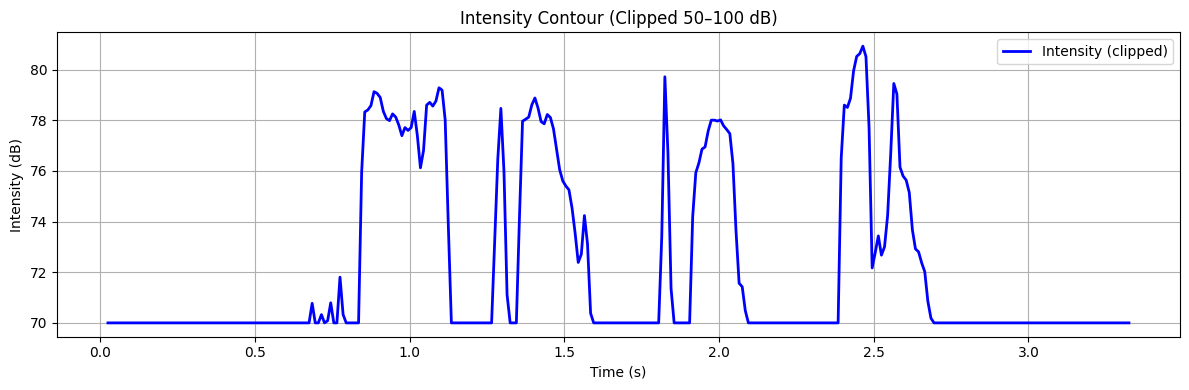

In [46]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt

def extract_intensity_parselmouth(wav_path,
                                   time_step=0.01,
                                   minimum_pitch=150.0,
                                   subtract_mean_pressure=True,
                                   clip_min_db=70.0,
                                   clip_max_db=100.0):
    """
    Extract intensity contour using Parselmouth and clip between [clip_min_db, clip_max_db].

    Returns:
        clipped_intensity: np.ndarray
        intensity_times: np.ndarray
        snd: parselmouth.Sound object
    """
    snd = parselmouth.Sound(wav_path)

    # Convert to Intensity object
    intensity = snd.to_intensity(minimum_pitch=minimum_pitch,
                                 time_step=time_step,
                                 subtract_mean=subtract_mean_pressure)

    # Extract values and times
    intensity_values = intensity.values[0]  # 1D array of dB values
    intensity_times = intensity.xs()        # Time stamps

    # Clip intensity between specified dB range
    intensity_values = np.clip(intensity_values, clip_min_db, clip_max_db)

    return intensity_values, intensity_times, snd


def draw_intensity_plot(intensity_values, intensity_times,
                        min_db=70.0, max_db=100.0,
                        title="Intensity Contour (Clipped 50–100 dB)"):
    """
    Plot the clipped intensity contour over time.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(intensity_times, intensity_values, color='blue', linewidth=2, label='Intensity (clipped)')
    plt.xlabel("Time (s)")
    plt.ylabel("Intensity (dB)")
    plt.title(title)
    plt.ylim()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# === Usage ===
wav_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053.wav"

# Extract clipped intensity
intensity_vals, intensity_times, snd = extract_intensity_parselmouth(wav_path)

# Plot intensity
draw_intensity_plot(intensity_vals, intensity_times)


In [41]:
intensity = snd.to_intensity?

Docstring: to_intensity(self: parselmouth.Sound, minimum_pitch: Positive[float] = 100.0, time_step: Optional[Positive[float]] = None, subtract_mean: bool = True) -> parselmouth.Intensity
Type:      method

✅ Intensity RMSE (clipped): 6.4997 dB


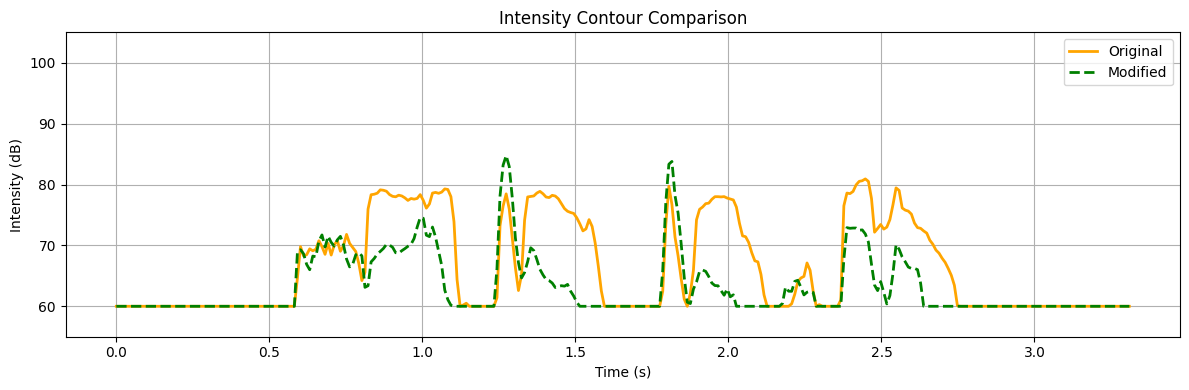

In [54]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt

def extract_intensity_parselmouth(wav_path,
                                   time_step=0.01,
                                   minimum_pitch=150.0,
                                   subtract_mean_pressure=True,
                                   clip_min_db=60.0,
                                   clip_max_db=100.0):
    """
    Extract intensity contour using Parselmouth and clip between [clip_min_db, clip_max_db].

    Returns:
        clipped_intensity: np.ndarray
        intensity_times: np.ndarray
        snd: parselmouth.Sound object
    """
    snd = parselmouth.Sound(wav_path)
    intensity = snd.to_intensity(minimum_pitch=minimum_pitch,
                                 time_step=time_step,
                                 subtract_mean=subtract_mean_pressure)

    intensity_values = intensity.values[0]
    intensity_times = intensity.xs()

    # Clip intensity to range
    intensity_values = np.clip(intensity_values, clip_min_db, clip_max_db)
    return intensity_values, intensity_times, snd


def draw_intensity_plot(times, intensity1, intensity2=None,
                        min_db=60.0, max_db=100.0,
                        title="Intensity Contour Comparison"):
    """
    Plot single or dual intensity contours.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(times, intensity1, label='Original', color='orange', linewidth=2)
    if intensity2 is not None:
        plt.plot(times, intensity2, label='Modified', color='green', linestyle='--', linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Intensity (dB)")
    plt.title(title)
    plt.ylim(min_db - 5, max_db + 5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_rmse(x, y):
    """
    Compute RMSE between two arrays.
    """
    diff = x - y
    return np.sqrt(np.mean(diff ** 2))


# === Paths ===
# orig_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053.wav"
# mod_path  = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053_-7_0.85.wav"


orig_path = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053.wav"
mod_path  = "/home/drsandipan/Desktop/VTLN-Experiment/Praat_Visulization_Code/Speech_Ocean/000010053_0.8.wav"

# === Extract intensities ===
intensity_orig, times_orig, _ = extract_intensity_parselmouth(orig_path)
intensity_mod,  times_mod,  _ = extract_intensity_parselmouth(mod_path)

# === Align lengths (pad shorter to match longer) ===
max_len = max(len(intensity_orig), len(intensity_mod))
intensity_orig = np.pad(intensity_orig, (0, max_len - len(intensity_orig)), constant_values=np.nan)
intensity_mod  = np.pad(intensity_mod,  (0, max_len - len(intensity_mod)),  constant_values=np.nan)

# Use common time axis (assuming same time_step and alignment)
common_times = np.linspace(0, max_len * 0.01, max_len)

# === Compute RMSE (ignoring NaNs) ===
valid_mask = ~np.isnan(intensity_orig) & ~np.isnan(intensity_mod)
rmse = compute_rmse(intensity_orig[valid_mask], intensity_mod[valid_mask])
print(f"✅ Intensity RMSE (clipped): {rmse:.4f} dB")

# === Plot Comparison ===
draw_intensity_plot(common_times, intensity_orig, intensity_mod)
